# R notebook for histology and growth performance data analysis of soy-tolerant rainbow trout (Tissues: plasma and intestine, RBT Strains: commercial and select strain, Diets: FM and PM)

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Fish Growth Overall - Updated Growth Data

In [2]:
allGrowthData <- read.csv('FishGrowthOverall.csv')
#allGrowthData

In [3]:
allGrowthData %>% 
    filter(Timepoint ==1) %>% 
    select(Cross, Avg_Start_Wt) %>% 
    mutate(Strain = ifelse(grepl("TL", Cross), "Com", "Sel"),
           Diet   = ifelse(grepl("F", Cross), "FM", "PM")) %>% 
    group_by(Strain) %>% 
    summarise(Mean = mean(Avg_Start_Wt),
              SD = sd(Avg_Start_Wt))

Strain,Mean,SD
<chr>,<dbl>,<dbl>
Com,6.750000,0.4460942
Sel,8.033333,0.1505545


In [4]:
#allGrowthData <- allGrowthData %>% filter(Timepoint !=3)
allGrowthData$Cross <- recode(allGrowthData$Cross, 
                              'TL-P' = "Com PM",
                              'TL-F' = 'Com FM',
                              'CX-AM-P' = 'Sel PM',
                              'CX-AM-F' = 'Sel FM')

allGrowthData <- allGrowthData %>% separate(Cross, 
                                            into=c('Strain', 'Diet'),
                                            sep=' ', 
                                            remove=FALSE) %>% mutate(Strain = as.factor(Strain),
                                                                     Diet = as.factor(Diet), 
                                                                     Timepoint = as.factor(Timepoint),
                                                                     Tank = as.factor(Tank),
                                                                     Cross = as.factor(Cross))

allGrowthData <- allGrowthData %>% mutate(Mort_Perc = (Morts/StartNo)*100)


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Saving 180 x 178 mm image
Saving 180 x 178 mm image


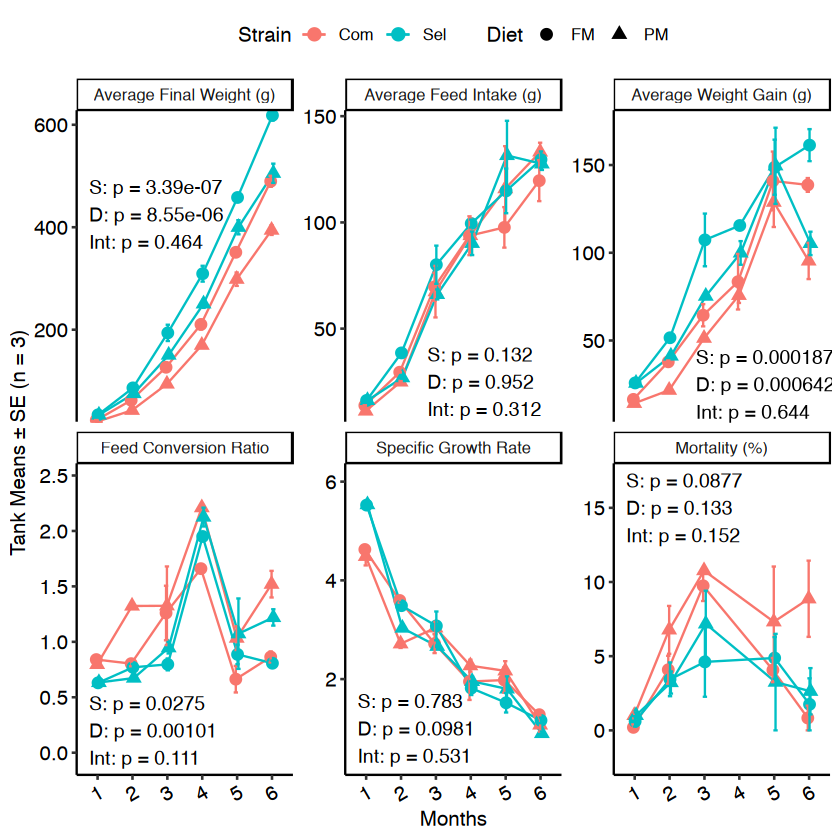

In [5]:
library(nlme)
library(ggh4x)

# --- Step 1. Outlier Detection and Data Preparation ---

# Define the growth metrics to include.
growth_vars <- c("Avg_End_Wt",
                 "Avg_Feed_Intake",
                 "Avg_Wt_Gain", 
                 "F.C.R.",
                 "SGR", 
                 "Mort_Perc")

# Remove outliers for each growth metric using the IQR rule.
# This function replaces outlier values with NA.
remove_outliers <- function(x) {
  x <- as.numeric(as.character(x))
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  lower <- Q1 - 1.5 * IQR_val
  upper <- Q3 + 1.5 * IQR_val
  ifelse(x < lower | x > upper, NA, x)
}

# Create a cleaned version of the growth data
allGrowthData_mod <- allGrowthData %>%
  mutate(across(all_of(growth_vars), remove_outliers)) %>%
  # Ensure numeric conversion for the growth metrics
  mutate(across(all_of(growth_vars), ~ as.numeric(as.character(.x))))

# Select metadata (Cross, Strain, Diet, Timepoint) and growth metrics, then pivot to long format.
growth_long <- allGrowthData_mod %>%
  select(Cross, Tank, Strain, Diet, Timepoint, all_of(growth_vars)) %>%
  pivot_longer(cols = all_of(growth_vars),
               names_to = "Metric",
               values_to = "Value")

# Remove rows with missing Value (due to outlier removal)
growth_long <- growth_long %>% filter(!is.na(Value))
# Sort facets of plots
growth_long$Metric <- factor(growth_long$Metric, levels = growth_vars)

# Define custom facet labels
custom_labels <- c(
  "Avg_End_Wt"      = "Average Final Weight (g)",
  "Avg_Wt_Gain"     = "Average Weight Gain (g)",
  "Avg_Feed_Intake" = "Average Feed Intake (g)",
  "F.C.R."          = "Feed Conversion Ratio",
  "SGR"             = "Specific Growth Rate",
  "Mort_Perc"           = "Mortality (%)"
)

# --- Step 3. Repeated Measures Analysis for Each Metric ---
# Here we assume Timepoint is a repeated measure (within each Cross).
# We'll fit an nlme model for each metric and extract p-values for Strain, Diet, and their interaction.

run_rm_anova <- function(metric_name, data) {
  df <- data %>% filter(Metric == metric_name)
  # Convert Timepoint to numeric (assuming it is coded as such; adjust if necessary)
  df <- df %>% mutate(TimepointNum = as.numeric(as.character(Timepoint)))
  
  # Fit a mixed-effects model with Cross as the subject
  model <- lme(Value ~ Strain * Diet * Timepoint, 
               random = ~1 | Tank, 
               correlation = corAR1(form = ~ TimepointNum | Tank),
               data = df)
  
  # Extract the ANOVA table for fixed effects
  anova_res <- anova(model)
  # Extract p-values (if an effect is missing, assign NA)
  p_strain <- if("Strain" %in% rownames(anova_res)) anova_res["Strain", "p-value"] else NA
  p_diet   <- if("Diet" %in% rownames(anova_res))   anova_res["Diet", "p-value"] else NA
  p_inter  <- if("Strain:Diet" %in% rownames(anova_res)) anova_res["Strain:Diet", "p-value"] else NA
  
  # Create a label string (here using plain text; you can later adjust to plotmath if desired)
  label <- paste("S: p =", signif(p_strain, 3),
                 "\nD: p =", signif(p_diet, 3),
                 "\nInt: p =", signif(p_inter, 3))
  return(label)
}

# Apply the function for each growth metric.
# We'll store the results in a named vector.
p_labels <- sapply(growth_vars, function(x) run_rm_anova(x, growth_long))

custom_y <- c(425, 25, 25, 0.2, 1, 15)
custom_x <- c(0.75, 2.75, 2.75, 0.75, 0.75, 0.75)  
                
custom_exp <- list(
  "Avg_End_Wt"      = c(0, 0),
  "Avg_Wt_Gain"     = c(0, 10),
  "Avg_Feed_Intake" = c(0, 5),
  "F.C.R."          = c(0, 0.4),
  "SGR"             = c(0, 0.8),
  "Mort_Perc"       = c(0, 3)
)                  
                   
# Create an annotation data frame for use in the plot.
# We'll position the annotation near the top of each facet.
# Here, we estimate y as the 95th percentile for each metric.
ann_df <- growth_long %>%
  group_by(Metric) %>%
  summarise(y_default = quantile(Value, 0.95, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(
    # If a metric is in custom_y, use that value; otherwise, use the computed default.
    y = ifelse(Metric %in% names(custom_y), custom_y[Metric], y_default),
    p_label = p_labels[Metric],
    x = custom_x  # x position for the annotation; adjust as needed
  )  # x-position; adjust as needed

# --- Summarize Data for Plotting ---
# Summarize mean and standard error (SE) for each combination of Timepoint, Strain, Diet, Cross, and Metric.
growth_summary <- growth_long %>%
  group_by(Timepoint, Strain, Diet, Cross, Metric) %>%
  summarise(mean_val = mean(Value, na.rm = TRUE),
            sd_val   = sd(Value, na.rm = TRUE),
            n = n(),
            se_val = sd_val / sqrt(n),
            .groups = "drop")

# --- Plotting: Faceted Plot with Mean, Error Bars, and Interaction Lines ---
p_growth <- ggplot(growth_summary, aes(x = Timepoint, y = mean_val, 
                                         color = Strain, shape = Diet, group = Cross)) +
  geom_line(position = position_dodge(width = 0.1)) +
  geom_point(size = 3, position = position_dodge(width = 0.1)) +
  geom_errorbar(aes(ymin = mean_val - se_val, ymax = mean_val + se_val), 
                width = 0.5, position = position_dodge(width = 0.1)) +
  facet_wrap(~ Metric, scales = "free_y", ncol = 3, 
             labeller = labeller(Metric = custom_labels)) +
  labs(x = "Months", y = "Tank Means ± SE (n = 3)") +
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1),
        strip.background = element_rect(fill = "white"),
        plot.title = element_text(hjust = 0.5)) +
  #scale_x_discrete(labels = c("1" = "28", "2" = "56", "3" = "84", "4" = "112", "5" = "140", "6" = "168")) + 
  facetted_pos_scales(y = list(
      Metric == "Avg_End_Wt"      ~ scale_y_continuous(expand = custom_exp[["Avg_End_Wt"]]),
      Metric == "Avg_Wt_Gain"     ~ scale_y_continuous(expand = custom_exp[["Avg_Wt_Gain"]]),
      Metric == "Avg_Feed_Intake" ~ scale_y_continuous(expand = custom_exp[["Avg_Feed_Intake"]]),
      Metric == "F.C.R."          ~ scale_y_continuous(expand = custom_exp[["F.C.R."]]),
      Metric == "SGR"             ~ scale_y_continuous(expand = custom_exp[["SGR"]]),
      Metric == "Mort_Perc"       ~ scale_y_continuous(expand = custom_exp[["Mort_Perc"]])
    )
  ) 

# Add p-value annotations for each facet using the annotation data frame.
p_growth <- p_growth + 
  geom_text(data = ann_df, 
            mapping = aes(x = custom_x, y = custom_y, label = p_label), 
            inherit.aes = FALSE, hjust = 0, size = 4)

# Display the plot
p_growth
ggsave('Figures/FINALFIGURE/FinalEPS/FIGURE1.eps', bg='white', dpi=600, unit="mm", width=180)
ggsave('Figures/FINALFIGURE/FinalEPS/FIGURE1.pdf', bg='white', dpi=600, unit="mm", width=180) 

# Intestinal histology data analysis

#### Read in the raw histology data

In [6]:
inthist <- read.csv('NathanCode//tidyhistintermediate.csv')

#### Adjusting group labels

In [7]:
inthist <- inthist %>% mutate(Villi_Length = as.numeric(Villi.length),
                              Villi_Width = as.numeric(Villi.width)) %>% select(-c(Villi.length, Villi.width, X, X.1))
inthist$Group <- str_replace_all(inthist$Group, c("ARS" = 'Sel', "TL" = "Com"))
inthist$Group <- factor(inthist$Group, levels = c('Com FM', 'Com PM','Sel FM', 'Sel PM'))

#### Generate boxplots with statistical testing using global ANOVA and pairwise t-test for quantitative histology measures - villi length and weight

In [8]:
# Split the "Group" column into "Strain" and "Diet" columns.
inthist <- inthist %>%
  separate(Group, into = c("Strain", "Diet"), sep = " ", remove = FALSE)

# Check the new columns:
head(inthist)

# Run a two-way ANOVA for Villi_Length including the interaction
model_length <- aov(Villi_Length ~ Strain * Diet, data = inthist)
summary(model_length)
anova_res_length <- summary(model_length)[[1]]
p_strain_length <- anova_res_length["Strain ", "Pr(>F)"]
p_diet_length <- anova_res_length["Diet", "Pr(>F)"]
p_inter_length <- anova_res_length["Strain:Diet", "Pr(>F)"]

p_label_length <- paste("S: p =", signif(p_strain_length, 3), 
                        "\nD: p =", signif(p_diet_length, 3),
                        "\nInt: p =", signif(p_inter_length, 3))
# For Villi Width:
model_width <- aov(Villi_Width ~ Strain * Diet, data = inthist)
summary(model_width)
anova_res_width <- summary(model_width)[[1]]
p_strain_width <- anova_res_width["Strain ", "Pr(>F)"]
p_diet_width <- anova_res_width["Diet", "Pr(>F)"]
p_inter_width <- anova_res_width["Strain:Diet", "Pr(>F)"]

p_label_width <- paste("S: p =", signif(p_strain_width, 3), 
                       "\nD: p =", signif(p_diet_width, 3),
                       "\nInt: p =", signif(p_inter_width, 3))

,Group,Strain,Diet,TIC,MF,GC,LP,SM,Villi_Length,Villi_Width
,<fct>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,Sel FM,Sel,FM,1,1,1,1,1,742,128
2,Sel FM,Sel,FM,1,1,1,1,1,701,139
3,Sel FM,Sel,FM,2,1,2,1,2,792,121
4,Sel FM,Sel,FM,1,1,1,1,1,670,109
5,Sel FM,Sel,FM,1,1,1,1,1,653,116
6,Sel FM,Sel,FM,1,1,1,2,2,689,112


             Df Sum Sq Mean Sq F value   Pr(>F)    
Strain        1   2924    2924   0.376   0.5412    
Diet          1 193379  193379  24.848 2.49e-06 ***
Strain:Diet   1  28162   28162   3.619   0.0599 .  
Residuals   104 809377    7782                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             Df Sum Sq Mean Sq F value   Pr(>F)    
Strain        1   2072    2072   2.899  0.09163 .  
Diet          1  26791   26791  37.491 1.65e-08 ***
Strain:Diet   1   7617    7617  10.659  0.00148 ** 
Residuals   104  74318     715                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

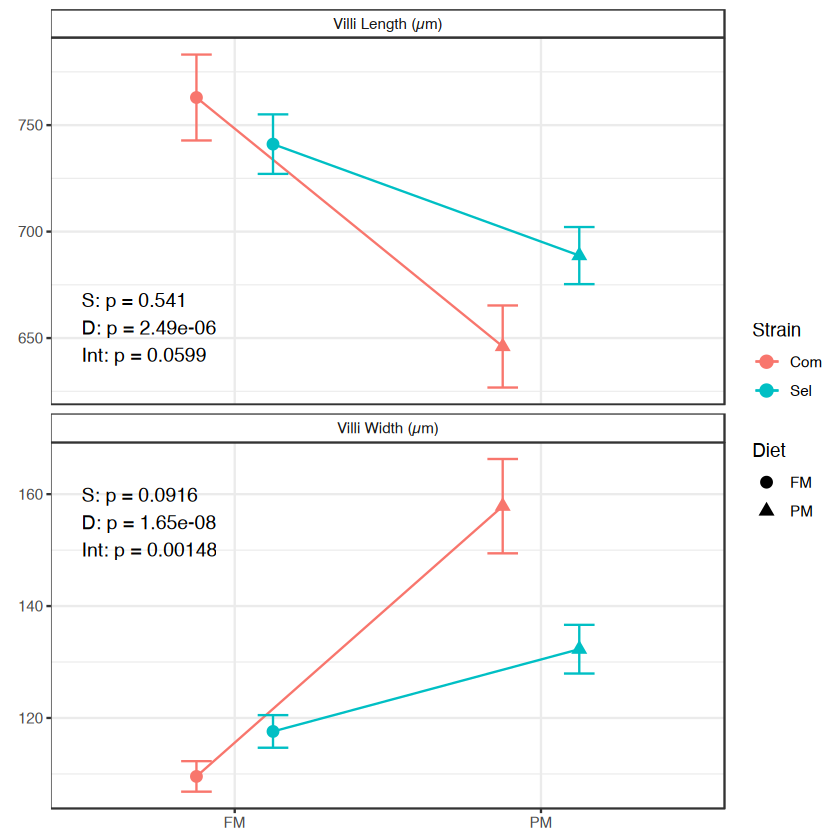

In [9]:
# Convert Villi_Length and Villi_Width to numeric if needed
inthist_mod <- inthist %>%
  mutate(Villi_Length = as.numeric(as.character(Villi_Length)),
         Villi_Width  = as.numeric(as.character(Villi_Width)))

# Pivot the measurements into long format
df_long <- inthist_mod %>%
  pivot_longer(cols = c(Villi_Length, Villi_Width), 
               names_to = "Measurement", 
               values_to = "Value") %>%
  mutate(Value = as.numeric(Value))

# Recoding measurement names for clearer facet labels
df_long <- df_long %>%
  mutate(Measurement = recode(Measurement, 
                              Villi_Length = "Villi Length (µm)",
                              Villi_Width  = "Villi Width (µm)"))

# --- Create Annotation Data Frame ---
# These x and y values might need adjustment based on your data range in each facet.
ann_df <- data.frame(
  Measurement = c("Villi Length (µm)", "Villi Width (µm)"),
  label = c(p_label_length, p_label_width),
  x = c(0.5, 0.5),   # x-coordinate for the annotation (Diet is on the x-axis)
  y = c(655, 155)  # y-coordinate; adjust as needed for your data ranges
)

# --- Plotting ---

# Create the faceted interaction plot.
# Points, lines, and error bars are dodged by Diet.
p_faceted <- ggplot(df_long, aes(x = Diet, y = Value, color = Strain, group = Strain, shape = Diet)) +
  stat_summary(fun = mean, geom = "point", size = 3, position = position_dodge(width = 0.5)) +
  stat_summary(fun = mean, geom = "line", position = position_dodge(width = 0.5)) +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2, position = position_dodge(width = 0.5)) +
  facet_wrap(~ Measurement, scales = "free_y", ncol = 1) +
  labs(y = element_blank()) +
  theme_bw() +
  theme(axis.title.x = element_blank(),
        #axis.text.x = element_text(angle = 70, hjust = 1),
        strip.background = element_rect(fill = "white"),
        plot.title = element_text(hjust = 0.5)) +
  scale_y_continuous(expand = c(0.05, 0.05))

# Overlay the p-value annotations on each facet.
p_faceted <- p_faceted + 
  geom_text(data = ann_df, aes(x = x, y = y, label = label), 
            inherit.aes = FALSE, hjust = 0, size = 4)

# Display the plot
p_faceted

#### Generate barplots of ordinal histological scoring data - plot by median with range error-bars

Loading required package: ARTool

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


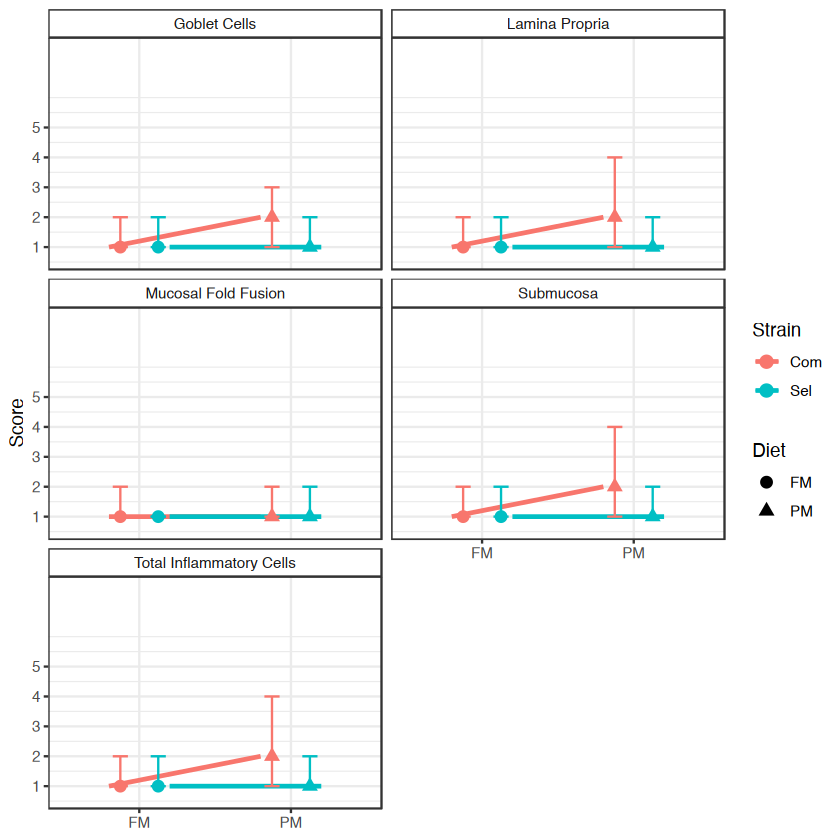

In [10]:
# Pivot the ordinal histology metrics into long format
inthistlong <- inthist %>% select(-c(Villi_Length,Villi_Width)) %>%
  pivot_longer(cols = c(TIC, MF, GC, LP, SM), 
               names_to = "Metric", 
               values_to = "Score") %>%
  mutate(Score = as.numeric(Score))

# Define the unique metrics and a function to run ART for each
metrics <- unique(inthistlong$Metric)

run_art <- function(metric_name){
  require(ARTool)
  df_metric <- inthistlong %>% filter(Metric == metric_name) %>% mutate(Strain = factor(Strain), Diet = factor(Diet))
  art_model <- art(Score ~ Strain * Diet, data = df_metric)
  art_summary <- anova(art_model)  # the ANOVA table from ART
  p_strain <- art_summary["Strain", "Pr(>F)"]
  p_diet <- art_summary["Diet", "Pr(>F)"]
  p_intxn <- art_summary["Strain:Diet", "Pr(>F)"]
  # Build a label
  label <- paste("S: p =", signif(p_strain, 3), 
                 "\nD: p =", signif(p_diet, 3),
                 "\nInt: p =", signif(p_intxn, 3))
  # Convert the expression to a character string (via as.expression if needed)
  # Here we return the expression directly; ggplot2 can render it.
  return(label)
}

# Create a named vector of labels for each metric
p_labels <- map_chr(metrics, ~ as.character(run_art(.x)))
names(p_labels) <- metrics

# Create a data frame for annotations, one row per Metric.
annotation_df <- data.frame(
  Metric = metrics,
  label = p_labels)


median_range <- function(x) {
  data.frame(
    y = median(x),
    ymin = min(x),
    ymax = max(x)
  )
}

custom_labels <- c(
  TIC = "Total Inflammatory Cells",
  MF  = "Mucosal Fold Fusion",
  GC  = "Goblet Cells",
  LP  = "Lamina Propria",
  SM  = "Submucosa"
)

# Create the barplot faceted by Metric. (Using ggbarplot from ggpubr)
P3_interaction <- ggplot(inthistlong, aes(x = Diet, y = Score, fill = Strain, color=Strain)) +
  #geom_boxplot(alpha = 0.7, position = position_dodge(width = 0.8)) +
  stat_summary(fun = median, geom = "line", aes(group = Strain, color=Strain), size = 1, position = position_dodge(width = 0.8)) +
  stat_summary(fun.data = median_range, geom = "errorbar", width = 0.2, 
               position = position_dodge(width = 0.5)) +
  stat_summary(fun = median, geom = "point", size = 3, aes(fill = Strain, shape = Diet), 
               position = position_dodge(width = 0.5)) +
  facet_wrap(~ Metric, ncol = 2, labeller = labeller(Metric = custom_labels)) +
  theme_bw() +
  theme(strip.background = element_rect(fill = "white"),
        #axis.text.x = element_text(angle = 0, hjust = 1),
        axis.title.x = element_blank()) +
  scale_y_continuous(breaks = seq(1, 5, 1), limits = c(0.25, 8), expand=c(0,0)) +
  labs(y = "Score")

P3_interaction

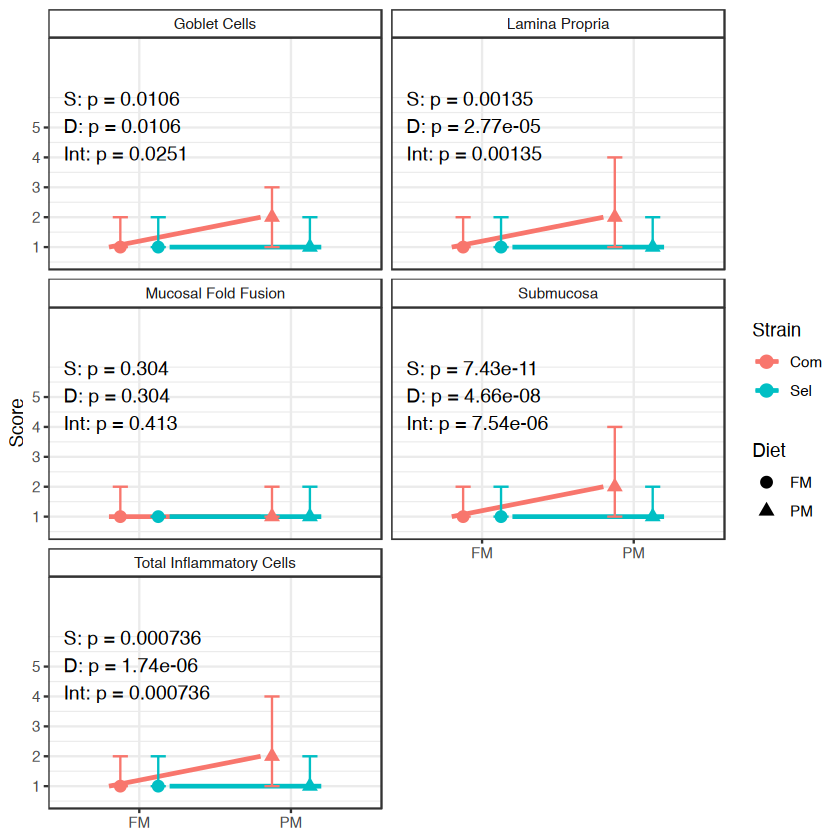

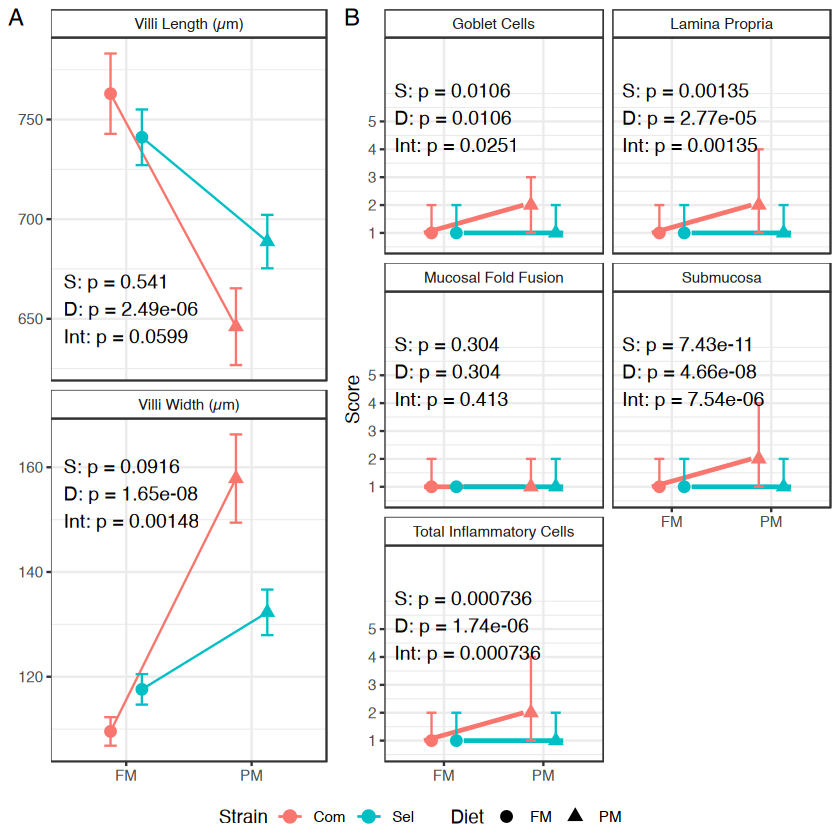

In [11]:
# Overlay the ART annotation on each facet.
# We add a geom_text layer using the annotation_df. Note: using 'inherit.aes = FALSE' allows us to use custom mapping.
P3_interaction <- P3_interaction + geom_text(data = annotation_df, 
                     mapping = aes(x = 0.5, y = 3.9, label = label), 
                     inherit.aes = FALSE,
                     hjust = 0, vjust = 0, 
                     size = 4)
P3_interaction

# Finally, arrange your histology plots with your other plot (P1_2) if needed:
histPlot <- ggarrange(p_faceted, P3_interaction, ncol = 2, widths = c(0.4, 0.6), labels = ('AUTO'), 
                     common.legend = TRUE, legend = 'bottom')
histPlot
# Optionally save:
#ggsave('Figures/HistPlot.tiff', histPlot, dpi = 600, width = 10, height = 7)

#### Multivariate multiple correspondance analyis (MCA) and plotting

#### Read in raw categorical data

In [12]:
# Load necessary libraries
library(FactoMineR)
library(factoextra)

# Data Preparation

# Assume 'inthist' is already loaded with columns:
# Group, Strain, Diet, TIC, MF, GC, LP, SM, Villi_Length, Villi_Width

# Convert Villi_Length and Villi_Width from factor to numeric
inthist_mod <- inthist %>%
  mutate(Villi_Length = as.numeric(as.character(Villi_Length)),
         Villi_Width  = as.numeric(as.character(Villi_Width)))

# Run MFA
MFA_data <- inthist_mod %>% select(TIC, MF, GC, LP, SM, Villi_Length, Villi_Width) %>% mutate(across(TIC:SM, as_factor))

# Run MFA on active_data, specifying group sizes accordingly:
mfa_res <- MFA(MFA_data, 
               group = c(5, 2), 
               type = c("n", "c"), 
               ncp = 5, 
               name.group = c("Ordinal", "Quantitative"))

# Extract the coordinates of individuals (rows) from MFA result
ind_coords <- as.data.frame(mfa_res$ind$coord)
# Add Strain and Diet information from original data
ind_coords$Strain <- inthist_mod$Strain
ind_coords$Diet   <- inthist_mod$Diet
ind_coords$Group  <- inthist_mod$Group

res.desc <- dimdesc(mfa_res, axes = 1:2, proba = 0.05)

# Run MANOVA on the first two dimensions:
manova_res <- manova(cbind(Dim.1, Dim.2) ~ Strain * Diet, data = ind_coords)
manova_sum <- summary(manova_res, test = "Pillai")

p_strain_manova <- manova_sum$stats[1,6]
p_diet_manova <- manova_sum$stats[2,6]
p_inter_manova <- manova_sum$stats[3,6]

p_label_manova <- paste("S: p =", signif(p_strain_manova, 3), 
                       "\nD: p =", signif(p_diet_manova, 3),
                       "\nInt: p =", signif(p_inter_manova, 3))

# Plot Individuals
# Create an interaction plot using the first two dimensions
p_mfa <- ggplot(ind_coords, aes(x = Dim.1, y = Dim.2, color = Strain, shape = Diet)) +
  geom_point(size = 3) +
  theme_bw() +
  labs(x = paste0("Dim 1 (",round(mfa_res$eig[1,2],1),"%)"),
       y = paste0("Dim 2 (",round(mfa_res$eig[2,2],1),"%)")) +  
  stat_ellipse(aes(group = Group, 
                   color = Strain,
                   linetype = Diet), type = "norm", level = 0.95, ) +
  annotate("text", x = -3, y = 6, label = p_label_manova, size = 4, hjust=0)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 99 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 88 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


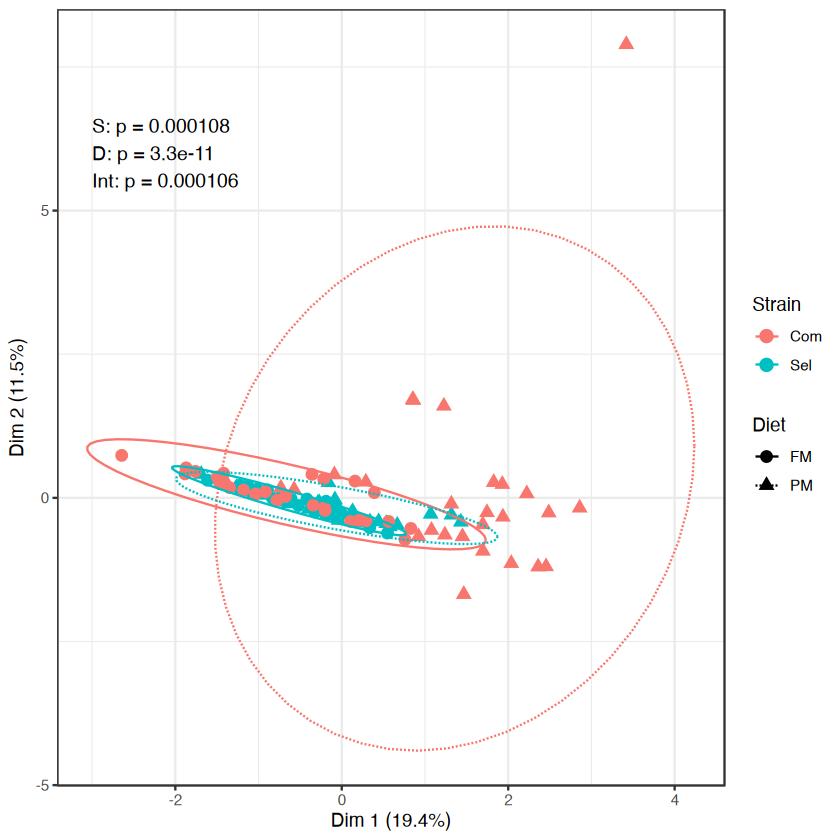

In [13]:
p_mfa

In [14]:
while(!is.null(dev.list())) dev.off()

In [15]:
HistoMultiPlot <- ggarrange(histPlot, ggarrange("",p_mfa, ncol=3,legend='none', widths=c(0.15,0.7,0.15), labels=c('', 'C')), ncol=1,heights=c(0.65, 0.35))
ggsave('Figures/FINALFIGURE/FinalEPS/FIGURE2.eps', bg='white', width=180, unit='mm', scale=1.1, dpi=600) 
ggsave('Figures/FINALFIGURE/FinalEPS/FIGURE2.pdf', bg='white', width=180, unit='mm', scale=1.1, dpi=600) 

Saving 198 x 196 mm image
Saving 198 x 196 mm image


In [16]:
head(res.desc)

,correlation,p.value
Villi_Width,0.3299525,4.879956e-04
Villi_Length,-0.8454899,1.197282e-30
,R2,p.value
TIC,0.45717333,8.928469e-14
SM,0.38662009,4.737064e-11
LP,0.26648443,4.350731e-07
MF,0.10127023,7.897624e-04
GC,0.09722281,4.655651e-03
,Estimate,p.value
LP=LP_3,1.9091926,2.012250e-08


#### list the median and range for each ordinal variable, by strain diet group

In [17]:
inthist %>% group_by(Group) %>% select(-Villi_Length,-Villi_Width) %>% mutate_at(vars(-Group, -Strain, -Diet), as.numeric) %>% summarise_all(median, na.rm=TRUE)
inthist %>% group_by(Group) %>% select(-Villi_Length,-Villi_Width) %>% mutate_at(vars(-Group, -Strain, -Diet), as.numeric) %>% summarise_all(max, na.rm=TRUE)

inthist %>% group_by(Group) %>% select(Group, Villi_Length,Villi_Width) %>% mutate_at(vars(-Group), as.numeric) %>% summarise_all(mean, na.rm=TRUE)
inthist %>% group_by(Group) %>% select(Group, Villi_Length,Villi_Width) %>% mutate_at(vars(-Group), as.numeric) %>% summarise_all(sd, na.rm=TRUE)

Group,Strain,Diet,TIC,MF,GC,LP,SM
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Com FM,Com,FM,1,1,1,1,1
Com PM,Com,PM,2,1,2,2,2
Sel FM,Sel,FM,1,1,1,1,1
Sel PM,Sel,PM,1,1,1,1,1


Group,Strain,Diet,TIC,MF,GC,LP,SM
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Com FM,Com,FM,2,2,2,2,2
Com PM,Com,PM,4,2,3,4,4
Sel FM,Sel,FM,2,1,2,2,2
Sel PM,Sel,PM,2,2,2,2,2


Group,Villi_Length,Villi_Width
<fct>,<dbl>,<dbl>
Com FM,762.9630,109.5556
Com PM,646.0370,157.8519
Sel FM,741.0741,117.5926
Sel PM,688.7407,132.2963


Group,Villi_Length,Villi_Width
<fct>,<dbl>,<dbl>
Com FM,104.79485,14.15663
Com PM,100.11473,43.79296
Sel FM,72.61221,15.13595
Sel PM,69.65939,22.60670
